In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load the dataset (replace with your actual file path)
#df = pd.read_csv('data/2024-06-01_2024-09-01/aggregated/percent_return.csv')
#df = pd.read_csv('data/2024-08-20_2024-08-28/aggregated/percent_return.csv')
df = pd.read_csv('data/2023-09-01_2024-09-01/aggregated/percent_return.csv') # 1 year's worth of data
clustered_df = pd.read_csv('data/Cluster_data/Clusters.csv')

# Extract stock names
stock_names = clustered_df.columns[1:]  # Assuming the first column is the date

# Get companies in Cluster 1, dropping any NaN values
cluster_3_companies = clustered_df['Cluster 3'].dropna().tolist()

# Filter the dataset to include only Cluster 1 companies
df_cluster_3 = df[['date'] + [col for col in df.columns if col in cluster_3_companies]]
df_cluster_3.head(11)
# Print the filtered DataFrame
counter=0
for col in df_cluster_3.columns:
    print(col)
    counter+=1
    print(counter)
df_cluster_3.to_csv("data\cluster_3")
#print(df) #every 5th row is a friday
#print(df) #every 5th row is a friday

date
1
A
2
AAPL
3
ABNB
4
ADSK
5
AEE
6
AEP
7
ALB
8
ALGN
9
ALL
10
ALLE
11
AMAT
12
AMCR
13
AMD
14
AME
15
AMGN
16
AMZN
17
ANET
18
AOS
19
APH
20
AVB
21
AVGO
22
AVY
23
AWK
24
BALL
25
BBY
26
BDX
27
BIIB
28
BKNG
29
BMY
30
CARR
31
CBOE
32
CE
33
CNC
34
CNP
35
CPRT
36
CPT
37
CRL
38
CRM
39
CRWD
40
CSCO
41
CSGP
42
CSX
43
CTLT
44
CTSH
45
D
46
DHI
47
DHR
48
DLR
49
DOV
50
DPZ
51
EFX
52
EL
53
EMN
54
EPAM
55
EQR
56
ESS
57
ETN
58
EXPE
59
FAST
60
FFIV
61
FICO
62
FTV
63
GE
64
GEN
65
GLW
66
GM
67
GOOG
68
GOOGL
69
GRMN
70
GWW
71
HD
72
HLT
73
HPE
74
HPQ
75
HST
76
IEX
77
INTC
78
INVH
79
IP
80
IPG
81
IR
82
IRM
83
JBL
84
JCI
85
JNPR
86
K
87
KDP
88
KIM
89
KLAC
90
KMX
91
KVUE
92
LEN
93
LKQ
94
LMT
95
LULU
96
MAA
97
MAR
98
MAS
99
MCHP
100
MET
101
MGM
102
MKC
103
MO
104
MPWR
105
MRNA
106
MSCI
107
MSFT
108
MSI
109
MTCH
110
MTD
111
MU
112
NEM
113
NOC
114
NRG
115
NTAP
116
NUE
117
NVDA
118
NWS
119
NWSA
120
O
121
ODFL
122
OMC
123
ON
124
ORCL
125
OTIS
126
PAYC
127
PCAR
128
PFE
129
PKG
130
PPG
131
PSA
132
PTC
133
PWR
134
QC

In [2]:
# Prepare the data for Monday to Thursday (features) and Friday (target)
X = []
y = []

# Iterate over the dataset in chunks of 5 rows (representing one week)
for i in range(0, len(df_cluster_3), 5):
    if i + 4 >= len(df_cluster_3):  # Prevent going out of bounds
        break
    # Monday to Thursday data (features)
    X.extend(df_cluster_3.iloc[i:i+4, 1:].T.values.tolist()) # rows are companies
    #X += df.iloc[i:i+4, 1:].T.values
    # Friday data (target)
    y.extend(df_cluster_3.iloc[i+4, 1:].T.values.tolist())  # Friday returns as target

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np

# Define the parameter distributions
param_dist = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2],
    'gamma': [0, 2, 4, 6, 8, 10],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'max_delta_step': [0, 2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 1, 2, 5, 10],  # L1 regularization
    'lambda': [1, 2, 4, 6, 8, 10],  # Adjusted L2 regularization
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings to sample
    scoring='r2',  # Optimize for R^2 score
    cv=TimeSeriesSplit(n_splits=5),  # 5-fold cross-validation, with time series(stock data)
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)

# Fit the random search
random_search.fit(X_train, y_train)

# Output best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

# Evaluate the model on the test set
predictions = best_model.predict(X_test)

Best Parameters: {'subsample': 0.5, 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 4, 'max_delta_step': 10, 'learning_rate': 0.04, 'lambda': 10, 'gamma': 8, 'alpha': 2}
Best R^2 Score: 0.3848351750309938


In [4]:
from sklearn.dummy import DummyRegressor

# Baseline model that predicts the mean y for all feature values
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)

In [5]:
# Calculate R^2 scores
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=tscv, scoring='r2')
print("Cross-Validation Scores (Training Data):", cv_scores)
print("Mean CV R^2 Score:", np.mean(cv_scores))

# Evaluate on test set
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test R^2 Score:", test_r2)

baseline_r2 = r2_score(y_test, baseline_predictions) # should be 0, since it predicts the mean
print(f"Baseline R^2 Score: {baseline_r2}")


Cross-Validation Scores (Training Data): [0.36728185 0.34468016 0.38228449 0.39643114 0.43349823]
Mean CV R^2 Score: 0.3848351750309938
Test R^2 Score: 0.35347468125574166
Baseline R^2 Score: -0.00029798514351786487


In [6]:
### Model evaluation
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse}")

# Calculate RMSE for baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print("Baseline RMSE:", baseline_rmse)
print("Model Improvement:", baseline_rmse - rmse)

Model RMSE: 1.6190736692235363
Baseline RMSE: 2.013902951770696
Model Improvement: 0.39482928254715954


In [7]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model RMSE: {rmse:.2f}")

# Calculate Baseline RMSE
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Model Improvement: {baseline_rmse - rmse:.2f}")

# Daily change standard deviation
daily_changes = np.diff(y_test).std()
print(f"Daily Change Std Dev: {daily_changes:.2f}")

Model RMSE: 1.62
Baseline RMSE: 2.01
Model Improvement: 0.39
Daily Change Std Dev: 2.87


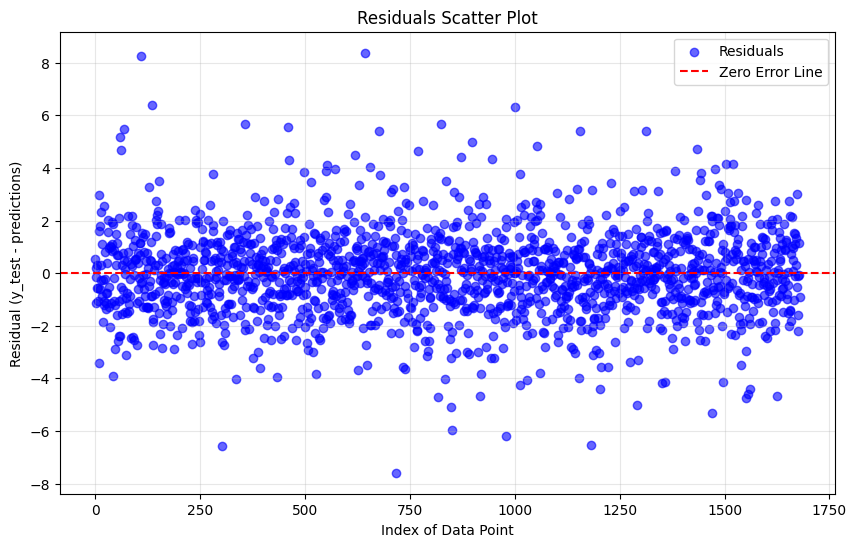

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Residuals (errors for each prediction)
residuals = y_test - predictions

# Scatter plot of residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('Residual (y_test - predictions)')
plt.title('Residuals Scatter Plot')
plt.legend()
plt.grid(alpha=0.3)

plt.show()


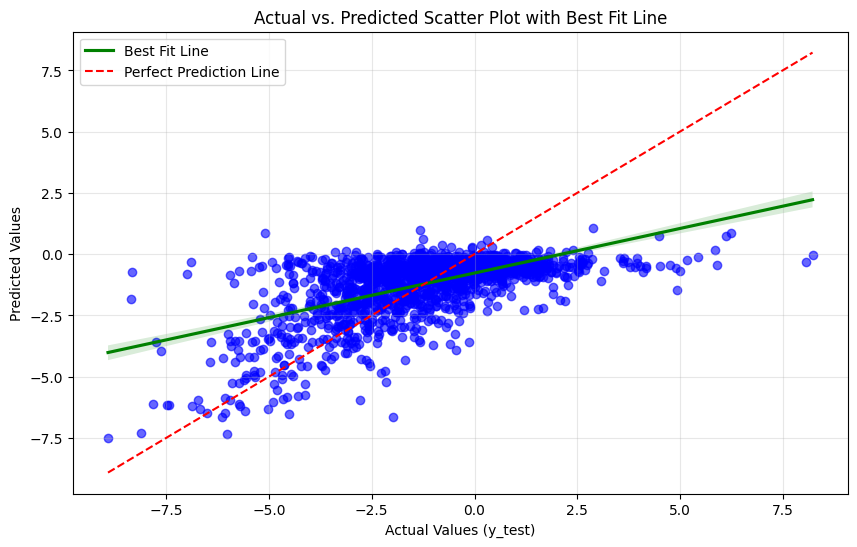

In [9]:
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=predictions, scatter_kws={'alpha': 0.6, 'label': 'Predicted vs. Actual'}, color='blue', line_kws={'color': 'green', 'label': 'Best Fit Line'})

# Add perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction Line')

# Labels and title
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Scatter Plot with Best Fit Line')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

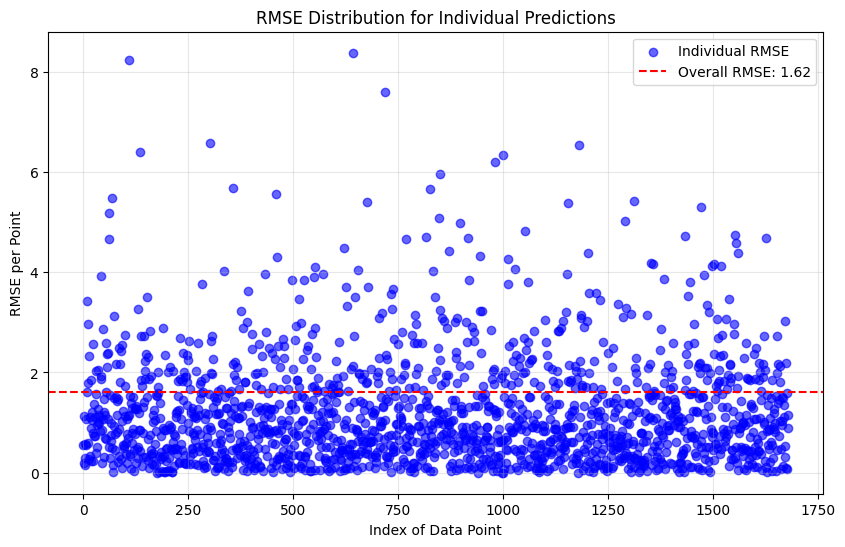

In [10]:
# Calculate individual RMSE values (absolute errors)
individual_rmse = np.sqrt((y_test - predictions) ** 2)

# Scatter plot of individual RMSE values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(individual_rmse)), individual_rmse, alpha=0.6, color='blue', label='Individual RMSE')
plt.axhline(y=rmse, color='red', linestyle='--', label=f'Overall RMSE: {rmse:.2f}')

# Labels and title
plt.xlabel('Index of Data Point')
plt.ylabel('RMSE per Point')
plt.title('RMSE Distribution for Individual Predictions')
plt.legend()
plt.grid(alpha=0.3)

plt.show()
